# CEIA - NLP Desafío N°3
## Villanueva Cecilia Azul


# Modelo de lenguaje con tokenización por caracteres

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


## Librerias y funciones

In [1]:
import random
import io
import pickle

from google.colab import files

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import pad_sequences # se utilizará para padding
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Embedding, Bidirectional

import urllib.request # descargar de textos.info
import bs4 as bs # Para leer y parsear el texto en HTML de wikipedia

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import softmax

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [2]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl,model_name,patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = history_ppl
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience
      self.model_name = model_name

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        self.history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save(f'{self.model_name}.keras')
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


In [3]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [4]:
def model_response(human_text,model):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word

In [5]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [6]:
# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)

def beam_search(model,num_beams,num_words,input,max_length,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input,max_length)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

## Datos
Utilizaremos como dataset **Alicia en el pais de las Maravillas de Lewis Carroll**, es una novela fantástica que narra la historia de Alicia, una niña que sigue a un conejo blanco con un reloj en su bolsillo y acaba cayendo por un agujero en el suelo, lo que la lleva a un mundo mágico y surrealista lleno de personajes extraños

In [7]:
raw_html = urllib.request.urlopen('https://www.textos.info/lewis-carroll/alicia-en-el-pais-de-las-maravillas/ebook')
raw_html = raw_html.read()

# Parsear artículo, 'lxml' es el parser a utilizar
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Encontrar todos los párrafos del HTML (bajo el tag <p>)
# y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text += para.text + ' '

# pasar todo el texto a minúscula
article_text = article_text.lower()

# en article text se encuentra el texto de todo el libro
article_text[:1000]

' en el dorado anochecer\r\nbogamos lentamente;\r\nlos brazos siéntense ceder\r\nal remo débilmente.\r\n¡qué dichoso desfallecer\r\nlas manos sin oriente! y qué implacable triple voz\r\nsuena en el dulce olvido\r\npidiendo extrañas invenciones,\r\nde quieto y lírico sentido.\r\n¿cómo callar indiferente\r\nsintiendo su latido? dice apremiante la primera\r\nvoz que comience el cuento,\r\nla segunda no nos reclama\r\nlógica de argumento,\r\ny nos acucia la tercera\r\ncon anheloso acento. ¡oh, qué silencio más profundo\r\nse impone a todo ruido!\r\nes la tierra un maravilloso\r\npaís desconocido,\r\nlleno de seres que convierten\r\nen real lo fingido. cuando la fuente imaginaria\r\nse agota en la inventiva\r\ny a los cristales del ensueño\r\nla luz se les esquiva:\r\n«¡siga el cuento —claman los seres—\r\nque tanto nos cautiva!» así el país maravilloso\r\nsobre el yunque del yo.\r\nepisodio tras episodio,\r\nsu leyenda forjó,\r\ny al ocaso, un mundo de amigos\r\nel alma nos pobló. recibe, 

### Elegir el tamaño del contexto

In [8]:
# seleccionamos el tamaño de contexto
max_context_size = 200

# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(article_text)

# la longitud de vocabulario de caracteres es:
len(chars_vocab)

# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

###  Tokenizar

In [9]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

tokenized_text[:10]

[15, 43, 60, 15, 43, 29, 15, 11, 1, 52]

### Organizando y estructurando el dataset

In [10]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1

num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

vocab_size = len(chars_vocab)
vocab_size

68

## Definición de Modelos y Entrenamiento

En esta sección se entrenarán los modelos propuestos: SimpleRNN, LSTM y GRU. Se utilizarán los datos de entrenamiento y validación preparados en las celdas previas. El entrenamiento se realizará durante 20 épocas o hasta que la métrica Perplejidad deje de mejorar en los datos de validación (utilizando Early Stopping)

### Modelo 1 - Simple RNN

El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas `CategoryEncoding` que transforma a índices a vectores OHE y `TimeDistributed` que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.

In [16]:
model_simpleRNN = Sequential([
    Input(shape=(None, 1)),
    TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot")),
    SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1),
    Dense(vocab_size, activation='softmax')
])

# Compilar el modelo
model_simpleRNN.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
model_simpleRNN.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_2 (TimeDistributed) │ (None, None, 68)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, None, 200)           │          53,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, None, 68)            │          13,668 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,468 (263.55 KB)

 Trainable params: 67,468 (263.55 KB)

 Non-trainable params: 0 (0.00 B)

#### Entrenamiento

In [17]:
history_ppl_sRNN= []
hist_simpleRNN = model_simpleRNN.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl_sRNN,model_name='model_simpleRNN')], batch_size=256)

Epoch 1/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 2.6616
 mean perplexity: 8.070463117680331 

Saved new model!
546/546 ━━━━━━━━━━━━━━━━━━━━ 52s 67ms/step - loss: 2.6610
Epoch 2/20
544/546 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2.0688
 mean perplexity: 7.321534335712047 

Saved new model!
546/546 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - loss: 2.0686
Epoch 3/20
545/546 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.9215
 mean perplexity: 7.05249409953531 

Saved new model!
546/546 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - loss: 1.9214
Epoch 4/20
545/546 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.8297
 mean perplexity: 7.00332016996914 

Saved new model!
546/546 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - loss: 1.8297
Epoch 5/20
545/546 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.7739
 mean perplexity: 7.094243764958851 

546/546 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - loss: 1.7739
Epoch 6/20
545/546 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.7345
 mean perplexity: 6.994627968467977 

Saved ne

In [19]:
# Guarda el modelo completo
#model_simpleRNN.save("model_simpleRNN.keras")
#files.download("model_simpleRNN.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

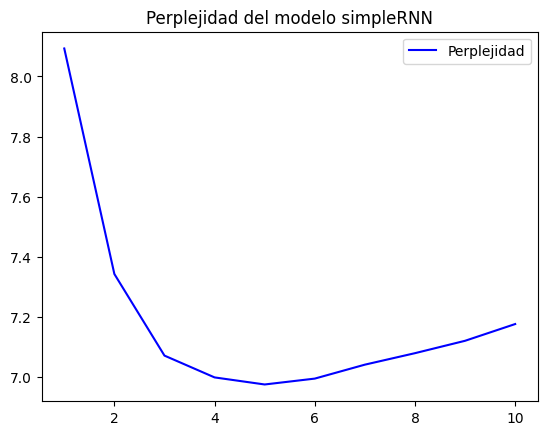

In [28]:
# Entrenamiento
epoch_count = range(1, len(history_ppl_sRNN) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl_sRNN, label='Perplejidad', color='blue')
plt.title('Perplejidad del modelo simpleRNN')
plt.show()

### Modelo 2 - LSTM

In [12]:
# Modelo basado en LSTM
model_LSTM = Sequential([
    Input(shape=(None, 1)),  # Define la entrada aquí
    TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot")),
    LSTM(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1),
    Dense(vocab_size, activation='softmax')
])

# Compilar el modelo
model_LSTM.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
model_LSTM.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_1 (TimeDistributed) │ (None, None, 68)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, None, 100)           │          67,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, None, 68)            │           6,868 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,468 (290.89 KB)

 Trainable params: 74,468 (290.89 KB)

 Non-trainable params: 0 (0.00 B)

#### Entrenamiento

In [13]:
history_ppl_LSTM = []
hist_LSTM = model_LSTM.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl_LSTM,model_name='model_LSTM')], batch_size=256)

Epoch 1/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - loss: 3.0124
 mean perplexity: 10.935684114397649 

Saved new model!
546/546 ━━━━━━━━━━━━━━━━━━━━ 302s 530ms/step - loss: 3.0119
Epoch 2/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - loss: 2.3461
 mean perplexity: 9.45476837512809 

Saved new model!
546/546 ━━━━━━━━━━━━━━━━━━━━ 315s 522ms/step - loss: 2.3460
Epoch 3/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - loss: 2.2029
 mean perplexity: 8.812424533952699 

Saved new model!
546/546 ━━━━━━━━━━━━━━━━━━━━ 328s 532ms/step - loss: 2.2029
Epoch 4/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - loss: 2.1297
 mean perplexity: 8.491418381561623 

Saved new model!
546/546 ━━━━━━━━━━━━━━━━━━━━ 312s 515ms/step - loss: 2.1297
Epoch 5/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - loss: 2.0792
 mean perplexity: 8.332083363605497 

Saved new model!
546/546 ━━━━━━━━━━━━━━━━━━━━ 323s 516ms/step - loss: 2.0792
Epoch 6/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - loss: 2.0417
 mean perpl

In [14]:
# Guarda el modelo completo
#model_simpleRNN.save("model_simpleRNN.keras")
#files.download("model_LSTM.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

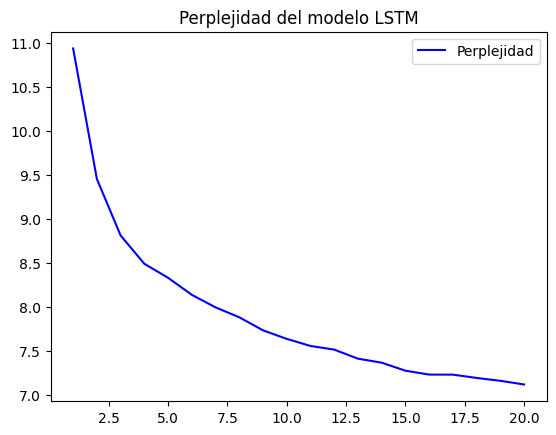

In [15]:
# Entrenamiento
epoch_count = range(1, len(history_ppl_LSTM) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl_LSTM, label='Perplejidad', color='blue')
plt.title('Perplejidad del modelo LSTM')
plt.show()

### Modelo 2.b - LSTM con Embeddings

In [21]:
model_emb_LSTM = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64),
    LSTM(64, recurrent_dropout=0.2, return_sequences=True),
    Dropout(0.3),
    Dense(vocab_size, activation="softmax")
])


model_emb_LSTM.build(input_shape=(None, 100))
model_emb_LSTM.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop")
model_emb_LSTM.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 64)             │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 100, 64)             │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 100, 68)             │           4,420 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,796 (163.27 KB)

 Trainable params: 41,796 (163.27 KB)

 Non-trainable params: 0 (0.00 B)

#### Entrenamiento

In [22]:
history_ppl_embLSTM = []
hist_embLSTM = model_emb_LSTM.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl_embLSTM,model_name='model_emb_LSTM')], batch_size=256)

Epoch 1/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - loss: 2.9052
 mean perplexity: 9.342023783524695 

Saved new model!
546/546 ━━━━━━━━━━━━━━━━━━━━ 318s 575ms/step - loss: 2.9046
Epoch 2/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - loss: 2.1989
 mean perplexity: 8.669120343705416 

Saved new model!
546/546 ━━━━━━━━━━━━━━━━━━━━ 315s 564ms/step - loss: 2.1988
Epoch 3/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - loss: 2.0996
 mean perplexity: 8.296199688884075 

Saved new model!
546/546 ━━━━━━━━━━━━━━━━━━━━ 332s 582ms/step - loss: 2.0996
Epoch 4/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - loss: 2.0453
 mean perplexity: 8.118464739203645 

Saved new model!
546/546 ━━━━━━━━━━━━━━━━━━━━ 309s 567ms/step - loss: 2.0453
Epoch 5/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - loss: 2.0069
 mean perplexity: 8.140623753478447 

546/546 ━━━━━━━━━━━━━━━━━━━━ 322s 566ms/step - loss: 2.0069
Epoch 6/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - loss: 1.9764
 mean perplexity: 8.06135966

In [23]:
# Guarda el modelo completo
#model_emb_LSTM.save("model_emb_LSTM.keras")
#files.download("model_emb_LSTM.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

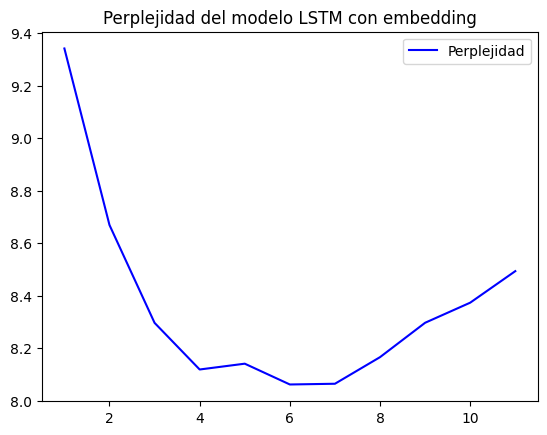

In [24]:
# Entrenamiento
epoch_count = range(1, len(history_ppl_embLSTM) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl_embLSTM, label='Perplejidad', color='blue')
plt.title('Perplejidad del modelo LSTM con embedding')
plt.show()

### Modelo 3

In [29]:
#Modelo GRU
model_GRU = Sequential([
    Input(shape=(None, 1)),
    TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot")),
    GRU(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1),
    Dense(vocab_size, activation='softmax')
])

# Compilar el modelo
model_GRU.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
model_GRU.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_3 (TimeDistributed) │ (None, None, 68)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, None, 100)           │          51,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, None, 68)            │           6,868 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,868 (226.05 KB)

 Trainable params: 57,868 (226.05 KB)

 Non-trainable params: 0 (0.00 B)

#### Entrenamiento

In [ ]:
history_ppl_GRU = []
hist_GRU = model_emb_LSTM.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl_GRU,model_name='model_GRU')], batch_size=256)

Epoch 1/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - loss: 1.8711
 mean perplexity: 8.50520125973593 

Saved new model!
546/546 ━━━━━━━━━━━━━━━━━━━━ 386s 708ms/step - loss: 1.8711
Epoch 2/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - loss: 1.8609
 mean perplexity: 8.524659544078546 

546/546 ━━━━━━━━━━━━━━━━━━━━ 409s 647ms/step - loss: 1.8609
Epoch 3/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - loss: 1.8521
 mean perplexity: 8.520969420065018 

546/546 ━━━━━━━━━━━━━━━━━━━━ 390s 663ms/step - loss: 1.8521
Epoch 4/20
163/546 ━━━━━━━━━━━━━━━━━━━━ 3:45 588ms/step - loss: 1.8455

In [ ]:
# Guarda el modelo completo
#model_GRU.save("model_GRU.keras")
files.download("model_GRU.keras")

In [ ]:
# Entrenamiento
epoch_count = range(1, len(history_ppl_GRU) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl_GRU, label='Perplejidad', color='blue')
plt.title('Perplejidad del modelo GRU')
plt.show()

## Resultados Entrenamiento

Se puede observar que SimpleRNN llegó a mejores resultados en cuanto a perplejidad.

Sin embargo, tanto para LSTM como para GRU se podría llegar a mejores resultados aún agregando épocas o ajustando hiperparámetros.

Debido a los costos de entrenamiento (complejidad computacional) se limitaron estas pruebas.


## Predicción del próximo caracter

In [ ]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model_simpleRNN = keras.models.load_model('model_simpleRNN.keras')
model_LSTM = keras.models.load_model('model_LSTM.keras')
model_emb_LSTM = keras.models.load_model('model_emb_LSTM.keras')
model_GRU= keras.models.load_model('model_GRU.keras')

Haremos la predicción del próximo caracter sobre la siguiente oración:

**"en un instante, alicia se metió detrás de él sin pensar ni remotamente si le sería posible salir"**

In [ ]:
text="en un instante, alicia se metió detrás de él sin pensar ni remotamente si le sería posible sali"

In [ ]:
print(f'Modelo Simple RNN: {model_response(text,model_simpleRNN)}')
print(f'Modelo LSTM: {model_response(text,model_LSTM)}')
print(f'Modelo LSTM con embedding: {model_response(text,model_emb_LSTM)}')
print(f'Modelo GRU: {model_response(text,model_GRU)}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step


'en un instante, alicia se metio detras de el sin pensar ni remotamente si le seria posible salir'

## Generación de secuencias

In [ ]:
input_text='en un instante, alicia se metio detras de el sin pensar ni '

In [ ]:
print(f'Modelo Simple RNN: {generate_seq(model_simpleRNN, input_text, max_length=max_context_size, n_words=30)}')
print(f'Modelo LSTM: {generate_seq(model_LSTM, input_text, max_length=max_context_size, n_words=30)}')
print(f'Modelo LSTM con embedding: {generate_seq(model_emb_LSTM, input_text, max_length=max_context_size, n_words=30)}')
print(f'Modelo GRU: {generate_seq(model_GRU, input_text, max_length=max_context_size, n_words=30)}')

'en un instante, alicia se metio detras de el sin pensar ni cantar a la cabeza de la cabez'

###  Beam search y muestreo aleatorio

In [ ]:
# predicción con beam search
print ('Temperatura=0.01')

salidas = beam_search(model_simpleRNN,num_beams=10,num_words=10,input=input_text,max_length=max_context_size,temp=0.01,mode='sto')
print(f'Modelo Simple RNN: {decode(salidas[0])}')

salidas = beam_search(model_LSTM,num_beams=10,num_words=10,input=input_text,max_length=max_context_size,temp=0.01,mode='sto')
print(f'Modelo LSTM: {decode(salidas[0])}')

salidas = beam_search(model_emb_LSTM,num_beams=10,num_words=10,input=input_text,max_length=max_context_size,temp=0.01,mode='sto')
print(f'Modelo LSTM con embedding: {decode(salidas[0])}')

salidas = beam_search(model_GRU,num_beams=10,num_words=10,input=input_text,max_length=max_context_size,temp=0.01,mode='sto')
print(f'Modelo GRU: {decode(salidas[0])}')

'en un instante, alicia se metio detras de el sin pensar ni cantar a l'

In [ ]:
# predicción con beam search
print ('Temperatura=0.5')

salidas = beam_search(model_simpleRNN,num_beams=10,num_words=10,input=input_text,max_length=max_context_size,temp=0.5,mode='sto')
print(f'Modelo Simple RNN: {decode(salidas[0])}')

salidas = beam_search(model_LSTM,num_beams=10,num_words=10,input=input_text,max_length=max_context_size,temp=0.5,mode='sto')
print(f'Modelo LSTM: {decode(salidas[0])}')

salidas = beam_search(model_emb_LSTM,num_beams=10,num_words=10,input=input_text,max_length=max_context_size,temp=0.5,mode='sto')
print(f'Modelo LSTM con embedding: {decode(salidas[0])}')

salidas = beam_search(model_GRU,num_beams=10,num_words=10,input=input_text,max_length=max_context_size,temp=0.5,mode='sto')
print(f'Modelo GRU: {decode(salidas[0])}')

In [ ]:
# predicción con beam search
print ('Temperatura=1')

salidas = beam_search(model_simpleRNN,num_beams=10,num_words=10,input=input_text,max_length=max_context_size,temp=1,mode='sto')
print(f'Modelo Simple RNN: {decode(salidas[0])}')

salidas = beam_search(model_LSTM,num_beams=10,num_words=10,input=input_text,max_length=max_context_size,temp=1,mode='sto')
print(f'Modelo LSTM: {decode(salidas[0])}')

salidas = beam_search(model_emb_LSTM,num_beams=10,num_words=10,input=input_text,max_length=max_context_size,temp=1,mode='sto')
print(f'Modelo LSTM con embedding: {decode(salidas[0])}')

salidas = beam_search(model_GRU,num_beams=10,num_words=10,input=input_text,max_length=max_context_size,temp=1,mode='sto')
print(f'Modelo GRU: {decode(salidas[0])}')